# Chapter 6 Decision Trees

Decision trees are a very versatile and powerful algorithm suitable for both classification and regression problems. The easiest way to get acquainted with them is, in my opinion, visualization rather than a verbal description. We will train our first decision tree on the iris dataset that we've already been using.

## Visualizing Decision Trees

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [2]:
IMAGES_DIR = 'images'

iris = load_iris()
# Petal length and width
X = iris.data[:, 2:]
# 3 classes
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

def image_path(fig_name):
    if not os.path.isdir(IMAGES_DIR):
        os.makedirs(IMAGES_DIR)
        print(f'Created directory {IMAGES_DIR}')
    return os.path.join(IMAGES_DIR, fig_name)
    
export_graphviz(
    tree_clf,
    out_file = image_path('iris_tree.dot'),
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded=True,
    filled=True
)

In [3]:
# Check whether we have created dot file
! ls "$IMAGES_DIR"

iris_tree.dot       iris_tree.png       regression_tree.dot regression_tree.png


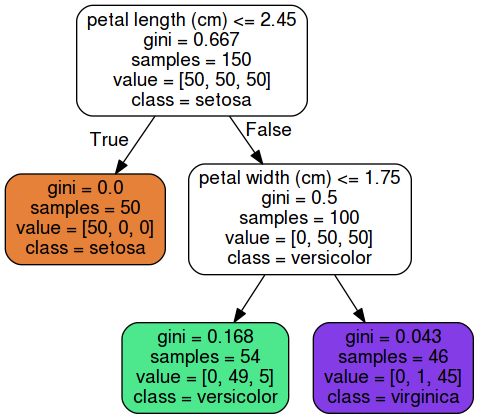

In [4]:
from IPython.display import Image

# Convert dot to png and display (make sure graphviz is installed)
bash_cmd = f'dot -Tpng {IMAGES_DIR}/iris_tree.dot -o {IMAGES_DIR}/iris_tree.png'
os.system(bash_cmd)
Image(filename = IMAGES_DIR + '/iris_tree.png')

We can see that at each node the tree makes a decision using the value of one variable until it gets to a leaf node, where it selects a class. For example, the root node checks whether petal width is less than or equal to 0.8, and moves to the left node if is True and the right node if it is False. We can also see the total number of instances and the number of instances in each class that satisfy the conditions of each node. Finally, we can see the value of the gini attribute, which is a measure of the impurity at each node. A completely pure node would have all its instances belonging in one class, and the most impure node would have an equal number of instances belonging to each class. A Gini score of 0 means a node is pure.

We can also visualize the decision boundaries created by this model.

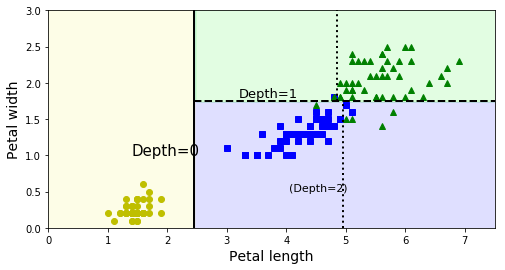

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11);

Decision trees can also output probabilities for each class by traversing the tree until it arrives at a leaf node and returning the relative proportion of instances for each class in that node.

In [6]:
print(tree_clf.predict_proba([[5, 1.5]]))
print(0/54, 49/54, 5/54)

[[0.         0.90740741 0.09259259]]
0.0 0.9074074074074074 0.09259259259259259


## Training Algorithm

sklearn uses the CART (Classification and Regression tree algorithm) to train decision trees. It does this by randomly selecting features and a threshold to split the current node into two subsets (other algorithms can create more subsets). It then splits based on whichever feature and threshold produces the most pure subsets weighted by their size. Purity is defined by the Gini score as mentioned above. sklearn also supports splitting based on information gain, or which split leads to the greatest decrease in [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In practice, whether one uses Gini impurity or entropy as a measure of purity makes [little practical difference](https://sebastianraschka.com/faq/docs/decision-tree-binary.html), but calculating the Gini score might be faster because it doesn't involve logs. The algorithm stops when further splits don't reduce impurity, or other stopping conditions defined by many possible hyperparameters. 

## Regularization Hyperparameters

There are a few hyperparameters that we could manipulate to deal with overfitting.

* __max_depth__ : maximum depth of tree
* __min_samples_split__ : minimum number of samples a node must have before it can be split
* __min_samples_leaf__ : minimum number of samples in a leaf node
* __min_weight_fraction_leaf__ : same as above but as a fraction of sum total of weights
* __max_leaf_nodes__ : maximum number of leaf nodes
* __max_features__ : maximum number of features evaluated when splitting at a node
* __min_impurity_decrease__ : minimum impurity decrease required to split a node 

Some algorithms regularize by creating a decision tree without restrictions and removing the splits that lead to a statistically insignificant impurity decrease.

## Regressors

Decision trees can also deal with regression by predicting the average value for all instances in a leaf node. The CART training algorithm works the same way but the criteria for splitting a node is to minimize the MSE rather than weighted impurity.

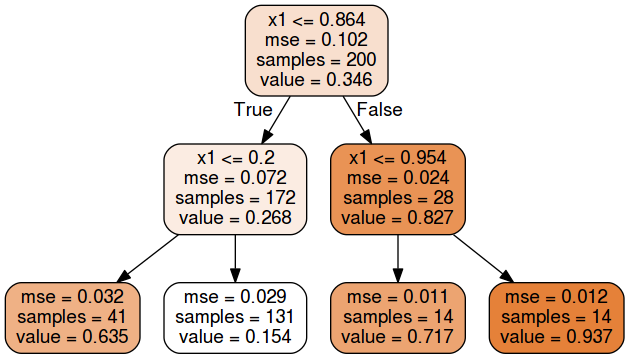

In [7]:
from sklearn.tree import DecisionTreeRegressor

m = 200 # number of instances
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

export_graphviz(
        tree_reg,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

bash_cmd = f'dot -Tpng {IMAGES_DIR}/regression_tree.dot -o {IMAGES_DIR}/regression_tree.png'
os.system(bash_cmd)
Image(filename = IMAGES_DIR + '/regression_tree.png')

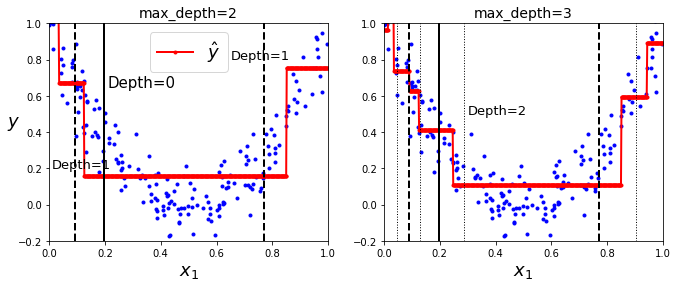

In [8]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14);

We can see that a decision tree regressor fits what looks like a step function to the data, since it predicts the same value for every instance in a single node.

## Instability

While decision trees are suitable for a wide variety of problems, they also suffer from a few problems. One is that they use orthogonal decision boundaries, so they are sensitive to data rotation. We can deal with this using the PCA method of dimensionality reduction. They are also sensitive to small changes in the data. The addition or removal of even one instance near a boundary can drastically change the structure of the decision tree. Let's use the tree we trained on the iris dataset above as an example. We will remove one point and see how the boundaries change. 

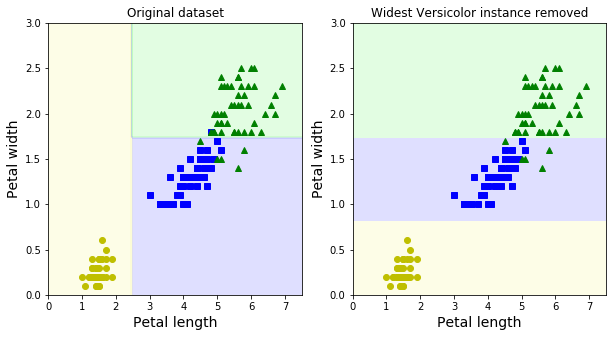

In [9]:
X = iris.data[:, 2:]
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title('Original dataset')
plt.subplot(122)
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked)
plt.title('Widest Versicolor instance removed');

We had to fix random_state for this result to be reliable, which is related to another issue with decision trees: we can get different structures for the same dataset because the decision trees randomly picks which features and thresholds to use for deciding how to split a node. This issue can be dealt with using random forest, which uses many decision trees on random subsets of the data and averages their results.